# Solving a discrete boundary-value problem in scipy

TAGS: Numpy & Scipy; Optimization and fitting techniques

## Mathematical formulation

We consider a nonlinear elliptic boundary-value problem in a square domain $\Omega = [0, 1] \times [0, 1]$:
$$
\Delta u + k f(u) = 0 \\
u = 0 \text{ on } \partial \Omega
$$

Here $u = u(x,y)$ is unknown function, $\Delta$ is [Laplace operator](https://en.wikipedia.org/wiki/Laplace_operator), $k$ is some constant and $f(u)$ is a given function.

A usual computational approach to such problems is discretization. We use a uniform grid with some step $h$, and define $u_{i, j} = u(i h , jh)$. By approximating Laplace operator using [5-point finite difference](https://en.wikipedia.org/wiki/Discrete_Laplace_operator) we get a system of equations in the form:
$$
u_{i - 1, j} + u_{i + 1, j} + u_{i, j - 1} + u_{i, j + 1} - 4 u_{i,j} + c f(u_{i,j}) = 0 \\
u_{i, j} = 0 \text{ on } \partial \Omega
$$

Here $c = k h^2$.

## Defining the problem for scipy

From now on we focus on the discrete version and consider a grid with $n = 100$ ticks for each dimension and set $c = 1$ and $f(u) = u^3$.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
from scipy.sparse import coo_matrix

In [2]:
n = 100
c = 1

In [3]:
def f(u):
    return u**3

def f_prime(u):
    return 3 * u**2

To solve the system of equations we will use `scipy.optimize.least_squares`. Now we need to setup our problem for `scipy`.

We define a function computing left-hand sides of all equations. Note that we assume values on the boundary to be fixed at zeros and don't change them during optimization.

In [4]:
def fun(u, n, f, f_prime, c=1, **kwargs):        
    v = np.zeros((n + 2, n + 2))
    u = u.reshape((n, n))
    v[1:-1, 1:-1] = u
    y = v[:-2, 1:-1] + v[2:, 1:-1] + v[1:-1, :-2] + v[1:-1, 2:] - 4 * u + c * f(u)
    return y.ravel()

It is always recommened to provide analytical Jacobian if possible. In our problem we have $n^2=10000$ equations and variables, but each equation depends only on a few variables, thus we should compute Jacobian in sparse format.

It is convenient to precompute indices of rows and columns of nonzero elements in Jacobian. We definte the corresponding function:

In [5]:
def compute_jac_indices(n):        
    i = np.arange(n)
    jj, ii = np.meshgrid(i, i)
    
    ii = ii.ravel()
    jj = jj.ravel()
    
    ij = np.arange(n**2)
    
    jac_rows = [ij]
    jac_cols = [ij]
        
    mask = ii > 0
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask - n)
        
    mask = ii < n - 1
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask + n)    
    
    mask = jj > 0
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask - 1)    
    
    mask = jj < n - 1
    ij_mask = ij[mask]
    jac_rows.append(ij_mask)
    jac_cols.append(ij_mask + 1)
    
    return np.hstack(jac_rows), np.hstack(jac_cols)    

After that computing Jacobian in `coo_matrix` format is simple:

In [6]:
def jac(u, n, f, f_prime, c=1, jac_rows=None, jac_cols=None):
    data = np.ones_like(jac_cols, dtype=float)    
    data[:n**2] = -4 + c * f_prime(u)    
    return coo_matrix((data, (jac_rows, jac_cols)), shape=(n**2, n**2))

## Solving the problem

Without any insight to the problem we set all the values to 0.5 initially. Note that it is not guranteed that given continuous or discrete problems have unique solution.

In [7]:
u0 = np.ones(n**2) * 0.5

Precompute rows and columns of nonzero elements in Jacobian:

In [8]:
jac_rows, jac_cols = compute_jac_indices(n)

Now we are ready to run the optimization. The first solution will be computed without imposing any bounds on the variables.

In [9]:
res_1 = least_squares(fun, u0, jac=jac, gtol=1e-3, args=(n, f, f_prime), kwargs={'jac_rows': jac_rows, 'jac_cols': jac_cols}, verbose=1)

`gtol` termination condition is satisfied.
Function evaluations: 106, initial cost: 1.0412e+02, final cost 5.2767e-03, first-order optimality 9.04e-04.


Below we visualize the first solution. The left plot shows the flatten solution, the middle plot shows how the solution looks in the square domain, and the right plot shows final residuals in each node.

/Users/nmayorov/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


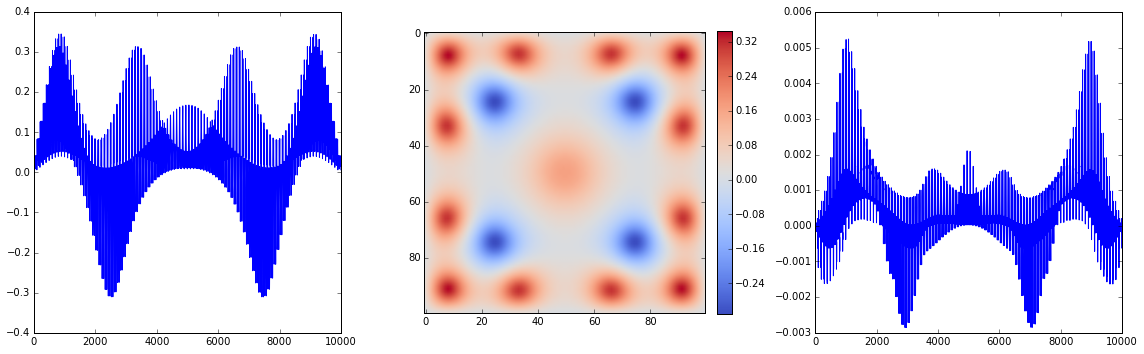

In [10]:
plt.figure(figsize=(16, 5))
plt.subplot(132)
plt.imshow(res_1.x.reshape((n, n)), cmap='coolwarm')
plt.colorbar(use_gridspec=True, fraction=0.046, pad=0.04)
plt.subplot(131)
plt.plot(res_1.x)
plt.subplot(133)
plt.plot(res_1.fun)
plt.tight_layout()

It is possible that some physical considerations require that the solution must be nonnegative everywhere. We can achieve that by specifying bounds to the solver:

In [11]:
res_2 = least_squares(fun, u0, jac=jac, bounds=(0, np.inf), gtol=1e-3,
                      args=(n, f, f_prime), kwargs={'jac_rows': jac_rows, 'jac_cols': jac_cols}, verbose=1)

`gtol` termination condition is satisfied.
Function evaluations: 34, initial cost: 1.0412e+02, final cost 4.1342e-02, first-order optimality 9.55e-04.


/Users/nmayorov/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


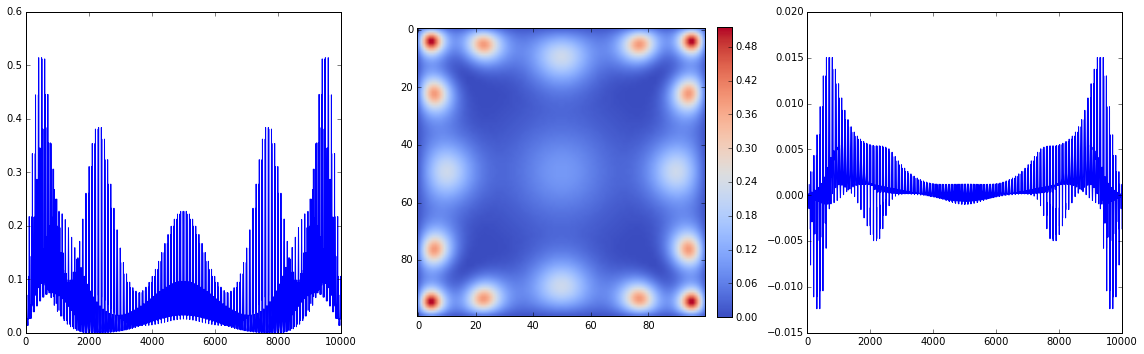

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(132)
plt.imshow(res_2.x.reshape((n, n)), cmap='coolwarm')
plt.colorbar(use_gridspec=True, fraction=0.046, pad=0.04)
plt.subplot(131)
plt.plot(res_2.x)
plt.subplot(133)
plt.plot(res_2.fun)
plt.tight_layout()

We see that setting a lower bound allowed us to find a different non-negative solution.

You can try running optimization from different starting points, using different bounds or changing $c$ and $f(u)$, and see how it affects the result of `least_squares` solver.